# Backtesting with Technical Analysis
we will be using ta library 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

In [3]:
data = pd.read_csv("aapl_5m_train.csv")

In [4]:
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


## Adding RSI

In [5]:
rsi_data = ta.momentum.RSIIndicator(close=data.Close, window=14)

In [6]:
data["RSI"] = rsi_data.rsi()
data = data.dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI
13,13,1609774500,0,2021-01-04 15:35:00,130.680694,131.139999,130.559997,131.115097,1150255.0,36.865564
14,14,1609774800,0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.884280
15,15,1609775100,0,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,32.020190
16,16,1609775400,0,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.523450
17,17,1609775700,0,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.909727


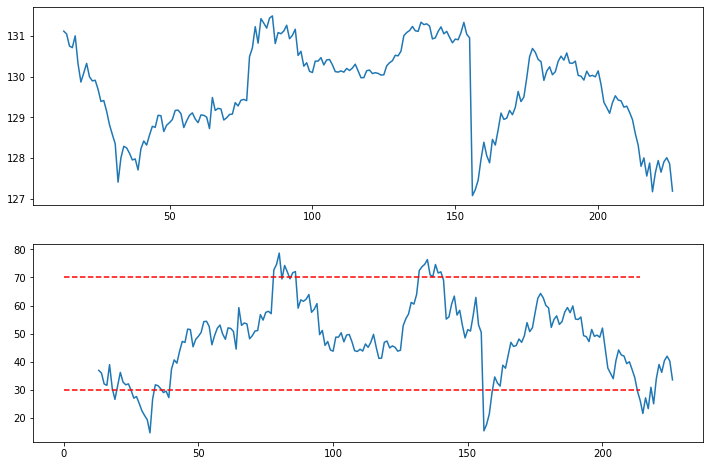

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))

#Price chart
axs[0].plot(data.Close[:214])

#Oscillator
axs[1].plot(data.RSI[:214])
axs[1].plot([0,214],[70, 70], 'r--', label="Upper Threshhold")
axs[1].plot([0,214],[30, 30], 'r--', label="Lower Threshhold")
plt.show()

## Adding SMA

In [8]:
short_ma = ta.trend.SMAIndicator(data.Close, window=5)
long_ma = ta.trend.SMAIndicator(data.Close, window=21)

In [9]:
data["SHORT_SMA"] = short_ma.sma_indicator()
data["LONG_SMA"] = long_ma.sma_indicator()
data = data.dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI,SHORT_SMA,LONG_SMA
33,33,1609780500,0,2021-01-04 17:15:00,127.410003,128.029998,126.760002,128.005004,2891333.0,26.712155,128.233343,129.705785
34,34,1609780800,0,2021-01-04 17:20:00,128.000793,128.399993,127.750000,128.289993,1956101.0,31.714234,128.127340,129.571257
35,35,1609781100,0,2021-01-04 17:25:00,128.289993,128.320007,127.889999,128.250000,1331407.0,31.390449,128.061340,129.438161
36,36,1609781400,0,2021-01-04 17:30:00,128.246902,128.310104,127.910003,128.119995,1314757.0,30.307246,128.014999,129.312928
37,37,1609781700,0,2021-01-04 17:35:00,128.125000,128.210006,127.889999,127.955001,982464.0,28.942233,128.123999,129.181748


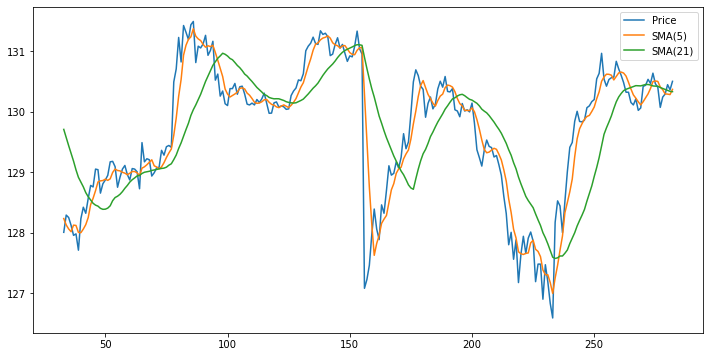

In [10]:
plt.figure(figsize=(12,6))
plt.plot(data.Close[:250], label="Price")
plt.plot(data.SHORT_SMA[:250], label="SMA(5)")
plt.plot(data.LONG_SMA[:250], label="SMA(21)")
plt.legend()
plt.show()

In [11]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, 
                 n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

In [12]:
data.iloc[0].SHORT_SMA

128.2333428

In [13]:
data.iloc[0].LONG_SMA

129.70578538095236

In [14]:
cash = 1_000_000
active_operations= []
com = 0.00125
strategy_value = []
n_shares = 40

sma_sell_signal = data.iloc[0].LONG_SMA > data.iloc[0].SHORT_SMA
sma_buy_signal = data.iloc[0].LONG_SMA < data.iloc[0].SHORT_SMA

for i, row in data.iterrows():
    #Close operations
    temp_operations = []
    for op in active_operations:
        # Close loosing position
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)
            
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
            
    
    # Do we have enough cash?
    if cash > row.Close * n_shares * (1 + com):
        # See if bus signal has changed...
        if row.LONG_SMA < row.SHORT_SMA and sma_buy_signal == False:
            sma_buy_signal = True
            # Buy...
            active_operations.append(Operation(operation_type="long", 
                                               bought_at=row.Close, 
                                               timestamp=row.Timestamp, 
                                               n_shares=n_shares,
                                               stop_loss=row.Close * 0.95,
                                               take_profit=row.Close * 1.05))
            cash -= row.Close * n_shares * (1 + com)
        elif row.LONG_SMA > row.SHORT_SMA:
            sma_buy_signal = False

            
        
        # Buy signal, if RSI < 30, buy...
#        if row.RSI < 30:
#            active_operations.append(Operation(operation_type="long", 
#                                               bought_at=row.Close, 
#                                               timestamp=row.Timestamp, 
#                                               n_shares=n_shares,
#                                               stop_loss=row.Close * 0.95,
#                                               take_profit=row.Close * 1.05))
#            cash -= row.Close * n_shares * (1 + com)
    else:
        print("No money...")
            
    # Calculate open positions value
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
    
    

In [ ]:
cash = 1_000_000
active_operations= []
com = 0.00125
strategy_value = []
n_shares = 40

sma_sell_signal = data.iloc[0].LONG_SMA > data.iloc[0].SHORT_SMA
sma_buy_signal = data.iloc[0].LONG_SMA < data.iloc[0].SHORT_SMA

# Modificación de la lógica para incluir operaciones en corto
for i, row in data.iterrows():
    # Cierre de operaciones
    temp_operations = []
    for op in active_operations:
        if op.operation_type == "long":
            # Cerrar posición perdedora o ganadora para operaciones en largo
            if op.stop_loss > row.Close or op.take_profit < row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        else:  # op.operation_type == "short"
            # Cerrar posición perdedora o ganadora para operaciones en corto
            if op.stop_loss < row.Close or op.take_profit > row.Close:
                cash += op.bought_at * op.n_shares * (1 + com) - row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # Implementación de la lógica de venta en corto
    if row.RSI > 70:  # Señal de venta en corto
        if cash > row.Close * n_shares * (1 + com) * 0.5:  # Uso del margen de cuenta, por ejemplo, el 50%
            active_operations.append(Operation(operation_type="short",
                                               bought_at=row.Close,
                                               timestamp=row.Timestamp,
                                               n_shares=n_shares,
                                               stop_loss=row.Close * 1.05,  # Ajuste para operaciones en corto
                                               take_profit=row.Close * 0.95))  # Ajuste para operaciones en corto
            cash -= row.Close * n_shares * (1 + com)  # Se asume que el margen se "usa" aunque no se gaste
        elif row.LONG_SMA > row.SHORT_SMA:
            sma_buy_signal = False

            
        
        # Buy signal, if RSI < 30, buy...
        if row.RSI < 30:
            active_operations.append(Operation(operation_type="long", 
                                               bought_at=row.Close, 
                                               timestamp=row.Timestamp, 
                                               n_shares=n_shares,
                                               stop_loss=row.Close * 0.95,
                                               take_profit=row.Close * 1.05))
            cash -= row.Close * n_shares * (1 + com)
    else:
        print("No money...")
            
    # Calculate open positions value
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)

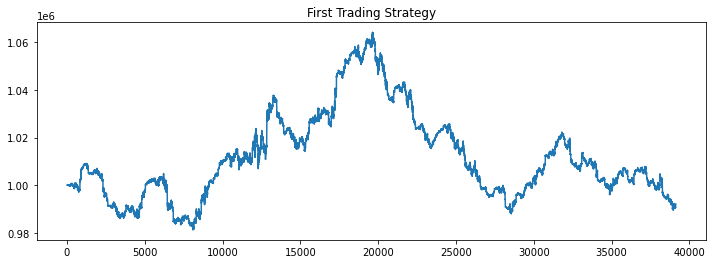

In [15]:
plt.figure(figsize=(12,4))
plt.plot(strategy_value)
plt.title("First Trading Strategy")
plt.show()

## Para el jueves hacer el short

Agregar:
- margin acc
    - 50% segun yo es como del 10%
- modificar casi todo el stop_loss y take_profit para considerar las ventas en corto

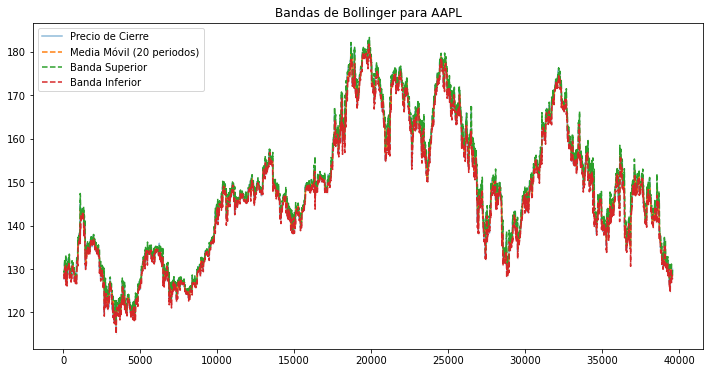

In [16]:
# Asegúrate de tener ta importada
# import ta


# Añade las bandas al DataFrame
# Cálculo de las Bandas de Bollinger
bb_indicator = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['bb_bbm'] = bb_indicator.bollinger_mavg()   # Media móvil
data['bb_bbh'] = bb_indicator.bollinger_hband()  # Banda superior
data['bb_bbl'] = bb_indicator.bollinger_lband()  # Banda inferior

# Para visualizar las Bandas de Bollinger junto con el precio de cierre
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Precio de Cierre', alpha=0.5)
plt.plot(data['bb_bbm'], label='Media Móvil (20 periodos)', linestyle='--')
plt.plot(data['bb_bbh'], label='Banda Superior', linestyle='--')
plt.plot(data['bb_bbl'], label='Banda Inferior', linestyle='--')
plt.fill_between(data.index, data['bb_bbh'], data['bb_bbl'], color='grey', alpha=0.1)  # Rellena el área entre las bandas
plt.title('Bandas de Bollinger para AAPL')
plt.legend()
plt.show()


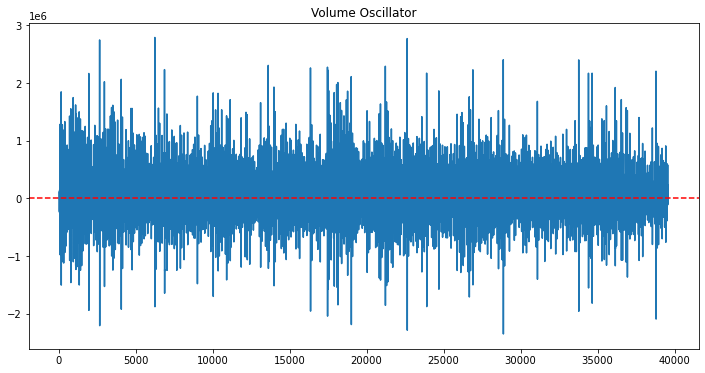

In [17]:


# Configura los periodos para las medias móviles corta y larga
short_window = 5
long_window = 10

# Calcula las medias móviles del volumen
data['short_ma_volume'] = data['Volume'].rolling(window=short_window).mean()
data['long_ma_volume'] = data['Volume'].rolling(window=long_window).mean()

# Calcula el Oscilador de Volumen
data['volume_oscillator'] = data['short_ma_volume'] - data['long_ma_volume']

# Visualización del Oscilador de Volumen
plt.figure(figsize=(12, 6))
data['volume_oscillator'].plot(title='Volume Oscillator')
plt.axhline(y=0, color='red', linestyle='--')  # Línea cero para referencia
plt.show()
